In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt


DEVICE = 'cuda'

SYSTEM_NAME = "ngc4414"
NSIM = 100

In [99]:
def get_config(system_name: str, nsub: str) -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config(f'config-sub{nsub}.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    uv = lambda u: (highs - lows) * u + lows
    
    print('lows', lows, lows.shape)
    print('highs', highs, highs.shape)
    
    return swyft.Prior(uv, 2), uv

def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
#     x_sub, y_sub = np.squeeze(v.T)
#     print(x_sub, y_sub)
#     print(torch.stack([x_sub, y_sub]).T)
#     d_p_sub = dist.Delta(torch.stack([x_sub, y_sub]).T).to_event(1)
#     print(d_p_sub)
#     print(x_sub, y_sub)
# #     print(torch.stack([x_sub, y_sub]).T)
#     d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)
#     print(d_p_sub)

    
#     print(d_p_sub)

#     d_p_sub = dist.Delta(v).to_event(1)
#     d_p_sub = dist.Delta(v.view(-1, 2)).to_event(1)

#     print(d_p_sub)

    print('v', v, v.shape)

#     x_sub, y_sub = np.squeeze(v.T)
#     print('x_sub', x_sub, x_sub.shape)
#     print('y_sub', y_sub, y_sub.shape)
#     xy_sub = torch.tensor([x_sub, y_sub])
#     print('xy_sub', xy_sub, xy_sub.shape)
#     d_p_sub = dist.Delta(xy_sub).to_event(1)
#     print('d_p_sub', d_p_sub)


#     xy_sub = v.view(-1, 2).to(DEVICE)

    if not torch.is_tensor(v):
        v = torch.tensor(v)

    xy_sub2 = v.view(-1,2).to(DEVICE)


#     if v.shape == (10,):
#         x_sub, y_sub = v[0::2], v[1::2]
# #         y_sub = v[1::2]
#     elif v.shape == (5,2):
#         x_sub, y_sub = np.squeeze(v.T)
#     else:
#         assert 1 == 2
#         x_sub = 0
#         y_sub = 0
#     print('x_sub', x_sub, x_sub.shape)
#     print('y_sub', y_sub, y_sub.shape)
#     xy_sub = torch.from_numpy(np.stack([x_sub, y_sub])).T.to(DEVICE)
    
    
#     print('xy_sub', xy_sub, xy_sub.shape)
    print('xy_sub2', xy_sub2, xy_sub2.shape)
    d_p_sub = dist.Delta(xy_sub2).to_event(1)
    print('d_p_sub', d_p_sub)
    
    print()


    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": config.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

In [100]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG1 = get_config(SYSTEM_NAME, '-1')
CONFIG5 = get_config(SYSTEM_NAME, '-5')
torch.set_default_tensor_type(torch.FloatTensor)

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd1 = CONFIG1.ppd()['model_trace'].nodes
ppd5 = CONFIG5.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

In [101]:
v1 = ppd1['main/sub/p_sub']['value']
print(v1)
v5 = ppd5['main/sub/p_sub']['value']
print(v5)

tensor([[-1.8423,  0.3936]], device='cuda:0')
tensor([[ 1.4480,  0.9376],
        [ 0.1266,  0.0768],
        [ 0.4678,  1.5959],
        [-1.7525, -2.1388],
        [ 0.1708, -0.9049]], device='cuda:0')


v tensor([[-1.8423,  0.3936]]) torch.Size([1, 2])
xy_sub2 tensor([[-1.8423,  0.3936]]) torch.Size([1, 2])
d_p_sub Independent(Delta(v: torch.Size([1, 2]), log_density: torch.Size([1, 2])), 1)



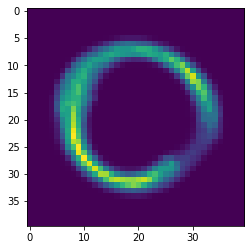

In [102]:
plt.imshow(simul(v1, CONFIG1)['image'])

v tensor([[ 1.4480,  0.9376],
        [ 0.1266,  0.0768],
        [ 0.4678,  1.5959],
        [-1.7525, -2.1388],
        [ 0.1708, -0.9049]]) torch.Size([5, 2])
xy_sub2 tensor([[ 1.4480,  0.9376],
        [ 0.1266,  0.0768],
        [ 0.4678,  1.5959],
        [-1.7525, -2.1388],
        [ 0.1708, -0.9049]]) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)



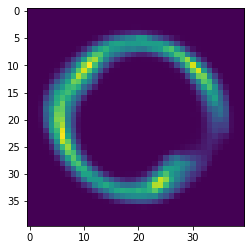

In [103]:
plt.imshow(simul(v5, CONFIG5)['image'])

In [104]:
CONFIG = CONFIG5
l = 5

prior, uv = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]

lows [-2.5 -2.5] (2,)
highs [2.5 2.5] (2,)


In [105]:
vv = v5.flatten().numpy()

def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    
    print(prior_p_sub)
    
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )

    
    nsub = main.sub.nsub
    lows = np.tile(lows, nsub)
    highs = np.tile(highs, nsub)
        
    
    uv = lambda u: (highs - lows) * u + lows
    
    
    return swyft.Prior(uv, 2*nsub), uv

prior, uv = get_prior(CONFIG5)

uv(vv)

Uniform(low: torch.Size([2]), high: torch.Size([2]))


array([  4.74018216,   2.18807697,  -1.8669641 ,  -2.11579084,
        -0.16112328,   5.47968388, -11.26243234, -13.19391012,
        -1.64619207,  -7.02466011])

In [106]:
def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    
    print('lows', lows, lows.shape, type(lows))
    print('highs', highs, highs.shape, type(highs))
    
    lows_l  = np.full((10), -2.5)
    highs_l = np.full((10), 2.5)
    
    print('lows', lows_l, lows_l.shape, type(lows_l))
    print('highs', highs_l, highs_l.shape, type(highs_l))
    
    lows = lows_l
    highs = highs_l
    
    
    uv = lambda u: (highs - lows) * u + lows
    
    
    
    return swyft.Prior(uv, 10), uv

prior, uv = get_prior(CONFIG)


pnames = [f'{z}_{i+1}' for i in range(l) for z in ['x', 'y']]
print(pnames)
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
#                             pnames = ["x_sub", "y_sub"],
                            pnames = pnames,
                            sim_shapes={"image": (nx, ny)})

store = swyft.MemoryStore(simulator=simulator)
store.add(NSIM, prior)
store.simulate()

lows [-2.5 -2.5] (2,) <class 'numpy.ndarray'>
highs [2.5 2.5] (2,) <class 'numpy.ndarray'>
lows [-2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5] (10,) <class 'numpy.ndarray'>
highs [2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5] (10,) <class 'numpy.ndarray'>
['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'x_4', 'y_4', 'x_5', 'y_5']
Creating new store.
Store: Adding 106 new samples to simulator store.
v [ 1.31780272 -0.59158361  1.53167065  0.0516701  -1.63348275 -1.27658082
 -1.76766661  0.5281519   0.28091045 -2.23521287] (10,)
xy_sub2 tensor([[ 1.3178, -0.5916],
        [ 1.5317,  0.0517],
        [-1.6335, -1.2766],
        [-1.7677,  0.5282],
        [ 0.2809, -2.2352]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [-1.87596699  1.61861968 -0.7781561   2.4432995   2.26561374 -1.11920178
 -0.47897819 -0.96177987  2.39492386  1.5177775 ] (10,)
xy_sub2 tensor([[-1.8760,  1.6186],
        [-0.7782,  2.4433],
 

d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 0.04414888  2.34085673 -0.65058195 -0.77832076  1.44479846  0.48295383
 -1.88631685 -2.28105953  1.20886611  0.22676821] (10,)
xy_sub2 tensor([[ 0.0441,  2.3409],
        [-0.6506, -0.7783],
        [ 1.4448,  0.4830],
        [-1.8863, -2.2811],
        [ 1.2089,  0.2268]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 1.21831492 -1.13670816 -0.59125683  1.5068678  -1.70279666 -2.46977813
 -0.53096411  0.862392    0.87984046 -0.65909373] (10,)
xy_sub2 tensor([[ 1.2183, -1.1367],
        [-0.5913,  1.5069],
        [-1.7028, -2.4698],
        [-0.5310,  0.8624],
        [ 0.8798, -0.6591]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [-0.789274    0.05910045  1.01175079 -1.7983054   0.16859278  1.0481448
  1.50889522  0.05935681 

d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 2.22390572 -1.68248736 -1.85440295 -0.1953076   0.84610698  1.5404549
 -1.80659284 -0.40562005  0.55240536  1.91130434] (10,)
xy_sub2 tensor([[ 2.2239, -1.6825],
        [-1.8544, -0.1953],
        [ 0.8461,  1.5405],
        [-1.8066, -0.4056],
        [ 0.5524,  1.9113]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 0.32279576  1.754169    2.10465494  1.71745393 -1.04871385  1.07106811
 -2.05002354  2.33400082 -1.35306045 -1.52928792] (10,)
xy_sub2 tensor([[ 0.3228,  1.7542],
        [ 2.1047,  1.7175],
        [-1.0487,  1.0711],
        [-2.0500,  2.3340],
        [-1.3531, -1.5293]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [-0.0139946   2.12535902  1.11973909 -1.03767537 -1.48146607 -1.31846825
  0.69631096  0.98362146 

v [ 1.34177383  0.87126152 -1.34396118 -0.65031683  0.61890789 -1.31136081
  2.40507525 -2.25180206 -0.72035378  1.33540194] (10,)
xy_sub2 tensor([[ 1.3418,  0.8713],
        [-1.3440, -0.6503],
        [ 0.6189, -1.3114],
        [ 2.4051, -2.2518],
        [-0.7204,  1.3354]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [-2.02768511  1.62449382 -0.92483831 -1.31547306  0.30362324 -1.19479768
 -0.41426298  1.95379825  1.0526606   1.20674517] (10,)
xy_sub2 tensor([[-2.0277,  1.6245],
        [-0.9248, -1.3155],
        [ 0.3036, -1.1948],
        [-0.4143,  1.9538],
        [ 1.0527,  1.2067]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [-2.38419952  1.45604055 -1.92023661  0.95554314  2.26474482  1.64167119
 -0.85675869  1.12674261 -1.38324038  2.11726825] (10,)
xy_sub2 tensor([[-2.3842,  1.4560],
        [-1.9202,  

In [107]:
store[0]

({'image': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])},
 array([ 1.31780272, -0.59158361,  1.53167065,  0.0516701 , -1.63348275,
        -1.27658082, -1.76766661,  0.5281519 ,  0.28091045, -2.23521287]))

In [71]:
pnames = [f'{z}_{i+1}' for i in range(l) for z in ['x', 'y']]
print(pnames)
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
#                             pnames = ["x_sub", "y_sub"],
                            pnames = pnames,
                            sim_shapes={"image": (nx, ny)})

store = swyft.MemoryStore(simulator=simulator)
store.add(NSIM, prior)
store.simulate()

['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'x_4', 'y_4', 'x_5', 'y_5']
Creating new store.
Store: Adding 86 new samples to simulator store.
v [ 0.72986559  2.21209927 -0.55763017 -0.1273882   0.6569171   0.70429052
  1.90181297  1.99294888 -0.62299621 -1.13441873] (10,)
x_sub [ 0.72986559 -0.55763017  0.6569171   1.90181297 -0.62299621] (5,)
y_sub [ 2.21209927 -0.1273882   0.70429052  1.99294888 -1.13441873] (5,)
xy_sub tensor([[ 0.7299,  2.2121],
        [-0.5576, -0.1274],
        [ 0.6569,  0.7043],
        [ 1.9018,  1.9929],
        [-0.6230, -1.1344]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [-0.66970948 -2.47162416 -0.03384295 -1.872263    0.2134996  -0.46180123
  1.03136557  0.51265337  1.84838501  2.14047088] (10,)
x_sub [-0.66970948 -0.03384295  0.2134996   1.03136557  1.84838501] (5,)
y_sub [-2.47162416 -1.872263   -0.46180123  0.51265337  2.14047088] (5,)
xy_sub tensor([[-0.6697, -2.471

v [ 1.68545014 -1.85416953  1.65615484  1.11667891  1.8560648  -1.610947
 -2.48452586 -1.28206673  1.86203683  0.19688216] (10,)
x_sub [ 1.68545014  1.65615484  1.8560648  -2.48452586  1.86203683] (5,)
y_sub [-1.85416953  1.11667891 -1.610947   -1.28206673  0.19688216] (5,)
xy_sub tensor([[ 1.6855, -1.8542],
        [ 1.6562,  1.1167],
        [ 1.8561, -1.6109],
        [-2.4845, -1.2821],
        [ 1.8620,  0.1969]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 2.2657394  -0.44461958 -0.44001167  1.74754061 -1.65150108 -2.44863217
 -1.214081    1.59743576 -1.36531327 -0.44144182] (10,)
x_sub [ 2.2657394  -0.44001167 -1.65150108 -1.214081   -1.36531327] (5,)
y_sub [-0.44461958  1.74754061 -2.44863217  1.59743576 -0.44144182] (5,)
xy_sub tensor([[ 2.2657, -0.4446],
        [-0.4400,  1.7475],
        [-1.6515, -2.4486],
        [-1.2141,  1.5974],
        [-1.3653, -0.4414]], dtype=torch.float64) torc

v [ 0.82247168  1.8366251   1.40772834 -0.57068657 -1.78084485  2.25631925
  0.63617419 -0.99189999 -0.07237793 -0.64178779] (10,)
x_sub [ 0.82247168  1.40772834 -1.78084485  0.63617419 -0.07237793] (5,)
y_sub [ 1.8366251  -0.57068657  2.25631925 -0.99189999 -0.64178779] (5,)
xy_sub tensor([[ 0.8225,  1.8366],
        [ 1.4077, -0.5707],
        [-1.7808,  2.2563],
        [ 0.6362, -0.9919],
        [-0.0724, -0.6418]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 2.03861915  0.93724705  0.27257447  0.39194791  1.98853183  1.49194222
 -0.47324376  2.03890423 -2.4057708  -1.81471747] (10,)
x_sub [ 2.03861915  0.27257447  1.98853183 -0.47324376 -2.4057708 ] (5,)
y_sub [ 0.93724705  0.39194791  1.49194222  2.03890423 -1.81471747] (5,)
xy_sub tensor([[ 2.0386,  0.9372],
        [ 0.2726,  0.3919],
        [ 1.9885,  1.4919],
        [-0.4732,  2.0389],
        [-2.4058, -1.8147]], dtype=torch.float64) to

v [ 1.86415638 -1.94116457 -1.73863685 -0.54572126 -0.27050856 -1.3648729
 -1.46507784  0.01835624  1.73583664 -0.42059344] (10,)
x_sub [ 1.86415638 -1.73863685 -0.27050856 -1.46507784  1.73583664] (5,)
y_sub [-1.94116457 -0.54572126 -1.3648729   0.01835624 -0.42059344] (5,)
xy_sub tensor([[ 1.8642, -1.9412],
        [-1.7386, -0.5457],
        [-0.2705, -1.3649],
        [-1.4651,  0.0184],
        [ 1.7358, -0.4206]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 2.14079003  1.08166084 -2.2084905  -1.32436879  1.34138423  0.28664325
 -2.29125861 -1.71665687 -0.74561139 -1.70684685] (10,)
x_sub [ 2.14079003 -2.2084905   1.34138423 -2.29125861 -0.74561139] (5,)
y_sub [ 1.08166084 -1.32436879  0.28664325 -1.71665687 -1.70684685] (5,)
xy_sub tensor([[ 2.1408,  1.0817],
        [-2.2085, -1.3244],
        [ 1.3414,  0.2866],
        [-2.2913, -1.7167],
        [-0.7456, -1.7068]], dtype=torch.float64) tor

v [-1.605502    2.22563128  1.31977592  1.39053851  2.13551869 -1.3999126
 -2.25009234 -2.22541716 -1.19377673 -0.5164715 ] (10,)
x_sub [-1.605502    1.31977592  2.13551869 -2.25009234 -1.19377673] (5,)
y_sub [ 2.22563128  1.39053851 -1.3999126  -2.22541716 -0.5164715 ] (5,)
xy_sub tensor([[-1.6055,  2.2256],
        [ 1.3198,  1.3905],
        [ 2.1355, -1.3999],
        [-2.2501, -2.2254],
        [-1.1938, -0.5165]], dtype=torch.float64) torch.Size([5, 2])
d_p_sub Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)

v [ 2.20926091  1.9959587   1.12839592 -1.54640272  0.46126174  0.32032555
  1.91485399 -0.33655597  1.46087188 -0.88847364] (10,)
x_sub [2.20926091 1.12839592 0.46126174 1.91485399 1.46087188] (5,)
y_sub [ 1.9959587  -1.54640272  0.32032555 -0.33655597 -0.88847364] (5,)
xy_sub tensor([[ 2.2093,  1.9960],
        [ 1.1284, -1.5464],
        [ 0.4613,  0.3203],
        [ 1.9149, -0.3366],
        [ 1.4609, -0.8885]], dtype=torch.float64) torch.Si

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 1.77173152  2.27898845 -2.45753004  0.60899848 -1.80107644  1.51611509
 -0.40842113 -0.31044012 -1.95929022 -0.61915549]


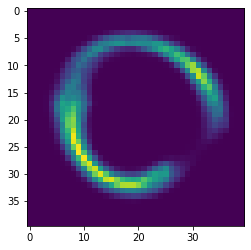

In [9]:
idx = 1

img = store[idx][0]['image']
v   = store[idx][1]
print(img)
plt.imshow(img)
print(v)